<img src="../logo_UTN.svg" align="right" width="200" /> 

# Tarea semanal 7
## Manuel Dieguez

# ¿Que vamos a estudiar en esta tarea?

Vamos a analizar el espectro del electrocardiograma en diferentes formas, y luego de ese analisis vamos a definir la plantilla de un filtro para el mismo

In [14]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
#from bartlett_periodogram import *
import scipy.io as sio
from scipy.io.wavfile import write

In [15]:
def vertical_flaten(a):

    return a.reshape(a.shape[0],1)

##################
# Lectura de ECG #
##################

fs_ecg = 1000 # Hz
N = 40000 
w = 10

# para listar las variables que hay en el archivo

mat_struct = sio.loadmat('./ECG_TP4.mat')

#ecg_one_lead = vertical_flaten(mat_struct['ecg_lead'])
ecg_one_lead = mat_struct['ecg_lead'].flatten()
qrs_detections = mat_struct['qrs_detections'].flatten()
ecg_one_lead_cut = ecg_one_lead[0:N]


Primero, vamos a analizar la PSD para:

 - Los primeros 40 segundos del ECG
 - Todas las realizaciones de los latidos en una ventana centrada en el latido de [-250 ms, +350 ms]
 - Todo el registro

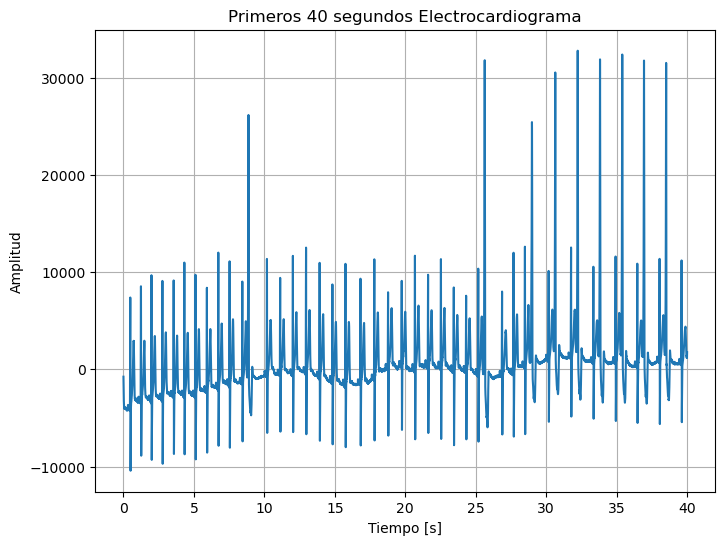

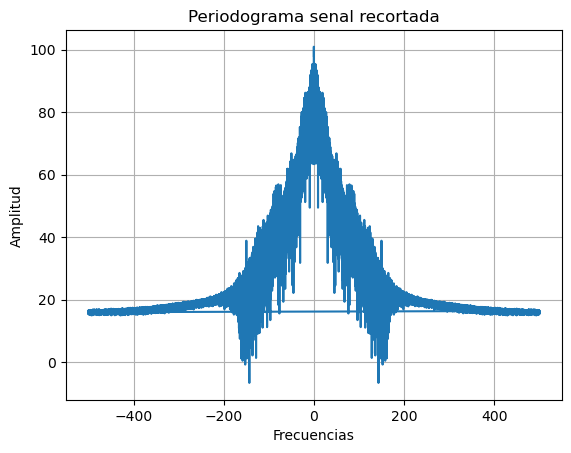

In [16]:
## Empezamos con los primeros 40 segundos del ECG

plt.figure(1,figsize=(8,6))
plt.title("Primeros 40 segundos Electrocardiograma")
plt.ylabel("Amplitud")
plt.xlabel("Tiempo [s]")
plt.plot(np.arange(0,N/fs_ecg,1/fs_ecg),ecg_one_lead_cut)
plt.grid()
plt.show()

freqs = np.fft.fftfreq(N, d=1/fs_ecg)
fft_ecg = np.fft.fft(ecg_one_lead_cut)
Pxx_ecg = np.abs(fft_ecg)**2/N

plt.figure(2)
plt.title("Periodograma senal recortada")
plt.xlabel("Frecuencias")
plt.ylabel(f"Amplitud")  ## Revisar LaTex
plt.plot(freqs,10*np.log10(Pxx_ecg))
plt.grid()
plt.show()

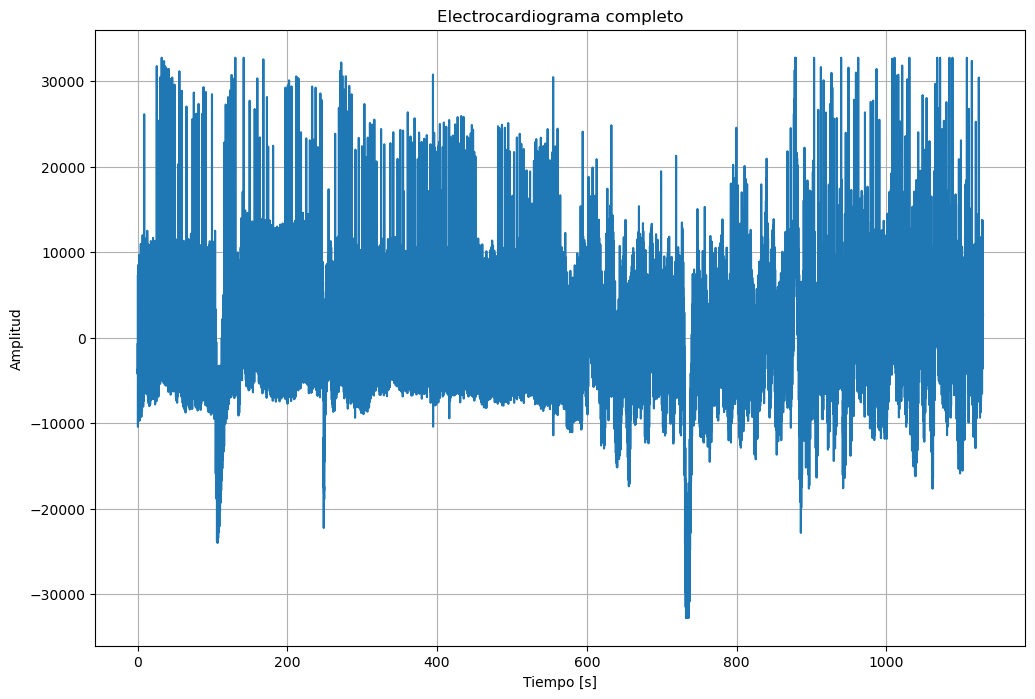

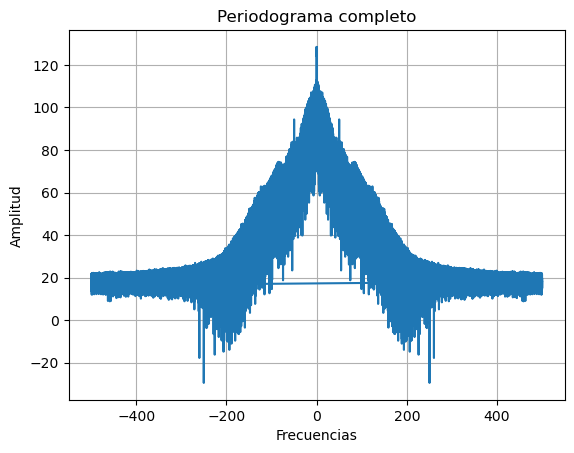

In [17]:
## Peridograma simple de la senal completa

freqs_full = np.fft.fftfreq(len(ecg_one_lead), d=1/fs_ecg)
fft_ecg_full = np.fft.fft(ecg_one_lead)
Pxx_ecg_full = np.abs(fft_ecg_full)**2/N

plt.figure(3,figsize=(12,8))
plt.title("Electrocardiograma completo")
plt.ylabel("Amplitud")
plt.xlabel("Tiempo [s]")
plt.plot(np.arange(0,len(ecg_one_lead)/fs_ecg,1/fs_ecg),ecg_one_lead)
plt.grid()
plt.show()

plt.figure(4)
plt.title("Periodograma completo")
plt.xlabel("Frecuencias")
plt.ylabel(f"Amplitud")  ## Revisar LaTex
plt.plot(freqs_full,10*np.log10(Pxx_ecg_full))
plt.grid()
plt.show()


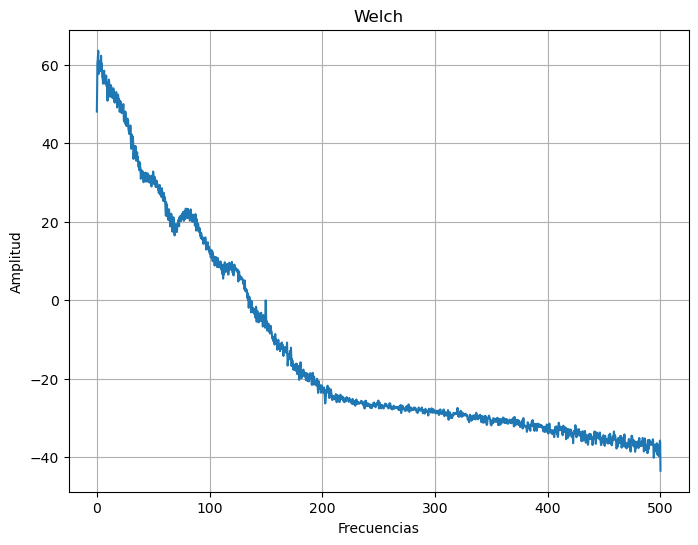

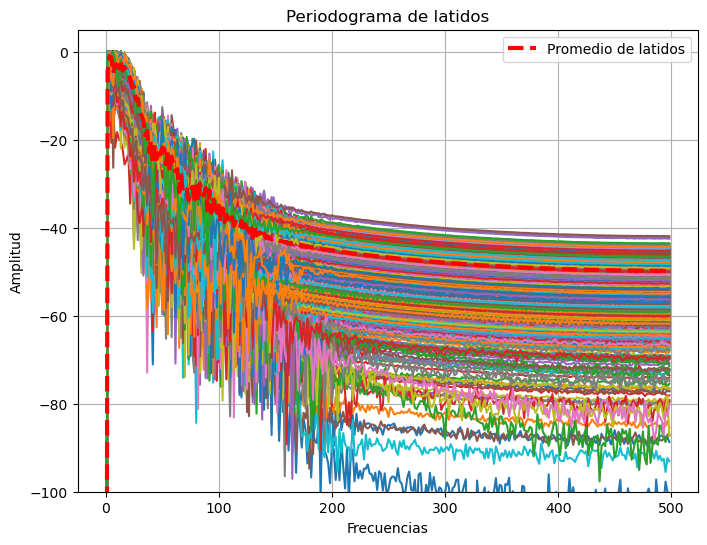

In [19]:
## Hacemos la estimacion de Welch para los primeros 10 segundos del ECG
[freqs_welch, fft_welch] = sc.signal.welch(ecg_one_lead_cut, fs_ecg, window = "hann", nperseg = int(N/w), detrend ="linear") ## Detrend saca la pendiente

plt.figure(5, figsize=(8,6))
plt.title("Welch")
plt.xlabel("Frecuencias")
plt.ylabel(f"Amplitud")  ## Revisar LaTex
plt.plot(freqs_welch,10*np.log10(fft_welch))
plt.grid()
plt.show()

# %%
## Separamos cada latido y realizamos la PSD

heartbeats = np.zeros([len(qrs_detections), 600])
heartbeats_ecg = np.zeros([len(qrs_detections), 600])
for i in range(len(qrs_detections)):
    heartbeats[i,:] = ecg_one_lead[qrs_detections[i]-250:qrs_detections[i]+350]
    heartbeats_ecg[i, :] = sc.signal.detrend(heartbeats[i,:])
    
fft_matrix = np.fft.fft(heartbeats_ecg)
Pxx_matrix = np.abs(fft_matrix)**2/600
for i in range(Pxx_matrix.shape[0]):
    Pxx_matrix[i, :] /= np.max(Pxx_matrix[i, :])
    Pxx_matrix[i,:] = np.fft.fftshift(Pxx_matrix[i,:])

Pxx_prom = np.mean(Pxx_matrix, axis = 0)
freqs_prom = np.fft.fftfreq(600, d = 1/fs_ecg)
freqs_prom = np.fft.fftshift(freqs_prom)

plt.figure(6, figsize=(8,6))
plt.title("Periodograma de latidos")
plt.xlabel("Frecuencias")
plt.ylabel(f"Amplitud")  ## Revisar LaTex
plt.ylim([-100,5])
for i in range(heartbeats_ecg.shape[0]):
    plt.plot(freqs_prom[300:],10*np.log10(Pxx_matrix[i,300:]))
plt.plot(freqs_prom[300:],10*np.log10(Pxx_prom[300:]), "--r",linewidth = 3, label = "Promedio de latidos")
plt.grid()
plt.legend()
plt.show()


Cabe destacar que cuando hacemos el periodograma de toda la muestra, reducen esos picos que aparecen el espectro relacionados a la varianza, esto mejora significativamente cuando promediamos los latidos aplicando el metodo de Welch, que reduce significativamente la varianza, mejorando significativamente la resolucion en amplitud del espectro

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


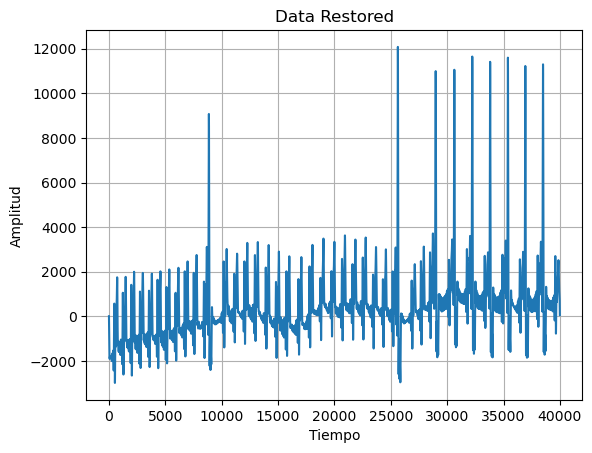

El ancho de banda de la senal para el 80% de la potencia es:  12.25 Hz


In [26]:
## Tomamos el BW a partir de Welch

BW_total_pow = 0.8
sumatoria = 0

per_norm = fft_welch/np.sum(np.abs(fft_welch))

for i in range(0,len(fft_welch)):
    sumatoria += np.abs(per_norm[i])
    index_bw = i
    if sumatoria >= BW_total_pow:
        break

BW = freqs_welch[index_bw]
fft_filter = np.zeros_like(fft_ecg)
fft_filter[:index_bw*w] = fft_ecg[:w*index_bw] ## w para reajustar lo que se achico el indice en welch

ecg_restored = np.fft.ifft(fft_filter)       ## No es el mejor porque transformo el brickwall

plt.figure(7)
plt.title("Data Restored")
plt.xlabel("Tiempo")
plt.ylabel(f"Amplitud")  ## Revisar LaTex
plt.plot(ecg_restored)
plt.grid()
plt.show()

print(f"El ancho de banda de la senal para el 80% de la potencia es: {BW: .2f} Hz")

Analizando el grafico, definimos la siguiente plantilla:

- ripple = 0.5
- atenuacion = 40
- frecuencia de corte inferior = 0.5
- frecuencia de corte superior = 30
- frecuencia de rechazo inferior = 0.1
- frecuencia de rechazo superior = 45